In [1]:
import os, sys
import numpy as np 
import sympy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
import math
import scipy as sci
from itertools import product 
from scipy.integrate import dblquad

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())


from src.basis.basis import BasisHandler
from src.operators import differentiate
from primitives import Primitives_MinimalSupport
from src.matrix_generation import assemble_matrix_integral_1d
from time import time

In [73]:
primitives = Primitives_MinimalSupport()
bh = BasisHandler(primitives=primitives, dimension=2)
bh.build_basis(J_0=3,J_Max=3,comp_call=True)


In [4]:
#Utility functions

def filter_type(elems, filter_type):
    elems_filt=[elem for elem in elems if elem["type"]==filter_type]
    return elems_filt

def _symmetric_toeplitz(first_row):
    first_row = np.asarray(first_row)
    return np.array([np.roll(first_row, -i) for i in range(len(first_row))])


def _wrap_matrix(v, M):
    v = np.asarray(v)
    M = np.asarray(M)
    n = M.shape[0]

    out = np.empty((n+2, n+2), dtype=M.dtype)
    out[1:-1, 1:-1] = M
    out[0, :] = v
    out[:, 0] = v
    out[-1, :] = v[::-1]
    out[:, -1] = v[::-1]

    return out

def boundary_toeplitz(rows:list[list]):
    """TODO write desc here"""
    M= _symmetric_toeplitz(rows[0])
    # print(rows[0])
    # print(M.shape)
    if len(rows) == 1:
        return M
    for row in rows[1:]:
        M = _wrap_matrix(row, M)
    return M


def _extend_zero_right(arr,n):
    if len (arr) <n:
        arr=arr+[0]*(n-len(arr))
    return arr

((0, 1), (0, 1))


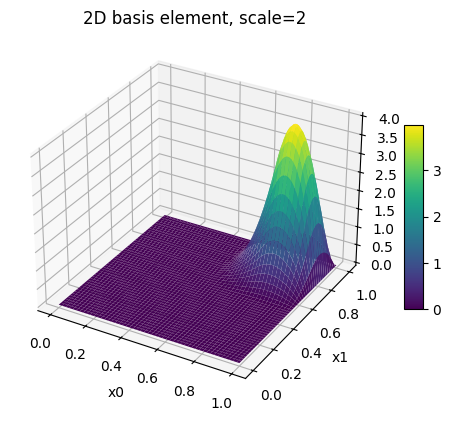

In [65]:
elems = bh.flatten()
center_scaling=filter_type(elems,filter_type=((0,0),(0,0)))
# elem=center_scaling[3]
elem=elems[15]
print(elem["type"])

x_range = np.linspace(0, 1, 200)
x0, x1 = sp.symbols("x0 x1")
f = sp.lambdify((x0, x1), elem["function_sym"](x0, x1), "numpy")
X, Y = np.meshgrid(x_range, x_range)
Z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_title(f"2D basis element, scale={elem['scale']}")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("f(x0, x1)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

In [117]:
#FFT laplacian and other kernels: 
# def fractional_laplacian_fft(f_vals, s, L=1.0):
#     """
#     Approximate (-Δ)^s f on a square box of side length L using FFT.
#     f_vals: (N, N) values of f on a uniform grid.
#     s: order of the operator (i.e. we apply (-Δ)^s).
#     L: physical length of the box in each dimension.
#     """
#     N = f_vals.shape[0]
#     h = L / N  # grid spacing

#     F = np.fft.fftn(f_vals)

#     kx = 2.0 * np.pi * np.fft.fftfreq(N, d=h)
#     ky = 2.0 * np.pi * np.fft.fftfreq(N, d=h)
#     KX, KY = np.meshgrid(kx, ky, indexing='ij')

#     symbol = (KX*KX + KY*KY)**s
#     symbol[0, 0] = 0.0  # kill DC

#     return np.real(np.fft.ifftn(symbol * F))

# def stiffness_entry_fft(f_i, f_j, s=1.0, N=256, x_min=-4.0, x_max=4.0):
#     """
#     Approximate A_ij = ∫ ((-Δ)^{s/2} φ_i)((-Δ)^{s/2} φ_j) dx
#     using FFT on [x_min, x_max]^2.

#     f_i, f_j: callables φ_i(x, y), φ_j(x, y) defined on R^2
#     s: fractional order in the PDE
#     N: grid size per dimension
#     x_min, x_max: box for the FFT (same in x and y)
#     """
#     L = x_max - x_min
#     h = L / N

#     # uniform grid on the chosen box
#     x = np.linspace(x_min, x_max, N, endpoint=False)
#     X, Y = np.meshgrid(x, x)

#     # sample basis functions
#     phi_i_vals = f_i(X, Y)
#     phi_j_vals = f_j(X, Y)

#     # apply (-Δ)^{s/2} to both
#     Ls2_phi_i = fractional_laplacian_fft(phi_i_vals, s/2, L=L)
#     Ls2_phi_j = fractional_laplacian_fft(phi_j_vals, s/2, L=L)

#     # discrete approximation of ∫ g_i g_j
#     Aij = np.sum(Ls2_phi_i * Ls2_phi_j) * (h * h)
#     return Aij
from numpy.polynomial.legendre import leggauss

def fractional_stiffness_entry(elem_i, elem_j, s: float=1, q: int = 8, C: float = 1.0) -> float:
    """
    Compute one stiffness matrix entry for the integral fractional Laplacian:

        A_ij = C * ∬ ((phi_i(x) - phi_i(y)) (phi_j(x) - phi_j(y))) / |x - y|^{2+2s} dx dy

    using tensor-product Gauss–Legendre quadrature, vectorized.

    elem_i, elem_j: Element dicts with:
        - 'function_num': callable f(x, y)
        - 'support': ((x0, x1), (y0, y1))
    s: fractional order (0 < s < 1 typical).
    q: Gauss–Legendre order per 1D dimension (8 is a good default).
    C: global constant factor for the operator; set it to your C_{2,s} if needed.
    """

    f_i = elem_i["function_num"]
    f_j = elem_j["function_num"]
    if f_i is None or f_j is None:
        raise ValueError("Both elements must have 'function_num' defined.")

    # Union of supports in x and y
    (xi0, xi1), (yi0, yi1) = elem_i["support"]
    (xj0, xj1), (yj0, yj1) = elem_j["support"]

    xmin = min(xi0, xj0)
    xmax = max(xi1, xj1)
    ymin = min(yi0, yj0)
    ymax = max(yi1, yj1)

    # 1D Gauss–Legendre nodes/weights on [-1, 1]
    gx, wx = leggauss(q)
    gy, wy = leggauss(q)

    # Map to [xmin, xmax] and [ymin, ymax]
    # x = 0.5 * (b - a) * t + 0.5 * (b + a)
    def map_interval(g, w, a, b):
        xm = 0.5 * (b - a) * g + 0.5 * (b + a)
        wm = 0.5 * (b - a) * w
        return xm, wm

    x_pts, x_w = map_interval(gx, wx, xmin, xmax)
    y_pts, y_w = map_interval(gy, wy, ymin, ymax)

    # 2D tensor-product grid for x and y (for the first variable)
    Xx, Xy = np.meshgrid(x_pts, y_pts, indexing="ij")
    Wx, Wy = np.meshgrid(x_w, y_w, indexing="ij")
    w_xy = (Wx * Wy).ravel()          # shape (M,)
    x_xy = Xx.ravel()                 # shape (M,)
    y_xy = Xy.ravel()                 # shape (M,)

    # Same grid for the second variable y (x', y')
    Yx, Yy = np.meshgrid(x_pts, y_pts, indexing="ij")
    Wx2, Wy2 = np.meshgrid(x_w, y_w, indexing="ij")
    w_xpyp = (Wx2 * Wy2).ravel()      # shape (N,)
    x_xpyp = Yx.ravel()               # shape (N,)
    y_xpyp = Yy.ravel()               # shape (N,)

    # Evaluate basis functions on both grids
    phi_i_xy  = f_i(x_xy,  y_xy)      # shape (M,)
    phi_i_xp  = f_i(x_xpyp, y_xpyp)   # shape (N,)
    phi_j_xy  = f_j(x_xy,  y_xy)      # shape (M,)
    phi_j_xp  = f_j(x_xpyp, y_xpyp)   # shape (N,)

    # Differences phi_i(x) - phi_i(y), phi_j(x) - phi_j(y)
    # shapes: (M, 1) - (1, N) -> (M, N)
    dphi_i = phi_i_xy[:, None] - phi_i_xp[None, :]
    dphi_j = phi_j_xy[:, None] - phi_j_xp[None, :]

    # Pairwise distances |x - y| in R^2
    dx = x_xy[:, None] - x_xpyp[None, :]
    dy = y_xy[:, None] - y_xpyp[None, :]
    r2 = dx*dx + dy*dy

    # Avoid division by zero on the diagonal (x = y).
    # In the continuum, that set has measure zero, so we can just zero those contributions.
    mask_zero = (r2 == 0.0)
    r2[mask_zero] = 1.0  # temporary to avoid inf
    kernel = 1.0 / (r2**((2.0 + 2.0*s) / 2.0))
    kernel[mask_zero] = 0.0

    # 4D weights: w(x) * w(y)
    W = w_xy[:, None] * w_xpyp[None, :]

    integrand = dphi_i * dphi_j * kernel

    Aij = C * np.sum(integrand * W)
    return Aij


In [100]:
elem1 = bh.flatten()[0]
elem2 = bh.flatten()[0]
print(elem1["shift"])
print(elem2["shift"])

start=time()
# a_ij = fractional_stiffness_entry(elem1["function_num"],elem2["function_num"], s=0.5, N=160)
a_ij=fractional_stiffness_entry(elem1,elem2, s=1)
end=time()
print(a_ij)
print(f"Time: {end-start}")

(1, 1)
(1, 1)
1006.3546303475202
Time: 0.0024688243865966797


In [118]:
def _comparison_heuristic(elem_a,elem_b):
    delta_1=elem_a["shift"][0]-elem_b["shift"][0]
    delta_2=elem_a["shift"][1]-elem_b["shift"][1]
    
    heuristic=(elem_a["type"][0][1],elem_a["type"][1][1],elem_b["type"][0][1],elem_b["type"][1][1],abs(delta_1),abs(delta_2))
    return heuristic


def big_chungus_I(basis:list,kernel):
    cache={}
    M=np.empty(shape=(len(basis),len(basis)))
    for i, j in product(list(range(len(basis))),repeat=2):
        elem_i=basis[i]
        elem_j=basis[j]
        h=_comparison_heuristic(elem_i,elem_j)
        # print(h, i , j)
        result=cache.get(h)
        if result:
            # print("using cache")
            M[i,j]=result
        else:
            # print("computing")
            result=kernel(elem_i,elem_j)
            M[i,j]=result
            if h[:4]==(0,0,0,0): #First version, center only.
                cache[h]=result
                h_p= h[:-2] + (h[-1], h[-2])
                cache[h_p]=result
        # print(result )
    return M
                  
    

[ 1.00635463e+03  2.50763208e+02 -2.60091745e+01 -3.49860004e+00
 -9.01613513e-01 -2.77500425e-01 -1.38917499e-01 -7.38844066e-02
  2.50763208e+02 -1.89109913e+01 -2.66331397e+01 -2.85932161e+00
 -7.99587981e-01 -2.60593985e-01 -1.33106128e-01 -7.15898520e-02
 -2.60091745e+01 -2.66331397e+01 -7.99392452e+00 -1.57186837e+00
 -5.53987623e-01 -2.13131126e-01 -1.16033374e-01 -6.47876802e-02
 -3.49860004e+00 -2.85932161e+00 -1.57186837e+00 -6.75713316e-01
 -3.14859286e-01 -1.49030164e-01 -8.89474242e-02 -5.26684877e-02
 -9.01613513e-01 -7.99587981e-01 -5.53987623e-01 -3.14859286e-01
 -1.78918462e-01 -1.00389691e-01 -6.57108141e-02 -4.15534680e-02
 -2.77500425e-01 -2.60593985e-01 -2.13131126e-01 -1.49030164e-01
 -1.00389691e-01 -6.55483543e-02 -4.70291819e-02 -3.18956211e-02
 -1.38917499e-01 -1.33106128e-01 -1.16033374e-01 -8.89474242e-02
 -6.57108141e-02 -4.70291819e-02 -3.59818052e-02 -2.57471560e-02
 -7.38844066e-02 -7.15898520e-02 -6.47876802e-02 -5.26684877e-02
 -4.15534680e-02 -3.18956

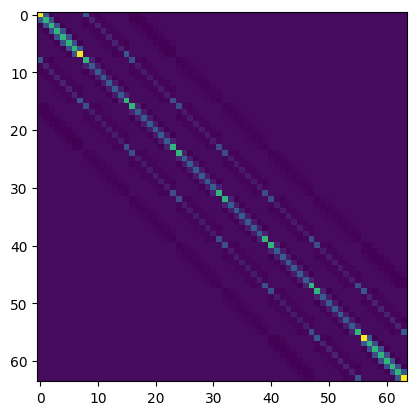

In [119]:
elems=bh.flatten()
center_scaling=filter_type(elems,filter_type=((0,0),(0,0)))
M=big_chungus_I(elems[:64],fractional_stiffness_entry)
# M=big_chungus_I(elems[:64],mass)
print(M[0,:])
plt.imshow(M)
plt.show()

In [48]:
def reconstruct_solution(coeffs, elements):
    def u(x, y):
        s = 0.0
        for c, elem in zip(coeffs, elements):
            f = elem["function_num"]
            s += c * f(x, y)
        return s
    return u

def l2_error(u_num, u_exact, n=200):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)

    diff = u_num(X, Y) - u_exact(X, Y)
    err_sq = diff**2

    dx = 1.0 / (n - 1)
    dy = 1.0 / (n - 1)

    return np.sqrt(np.sum(err_sq) * dx * dy)

L2 error: 0.449282780340572


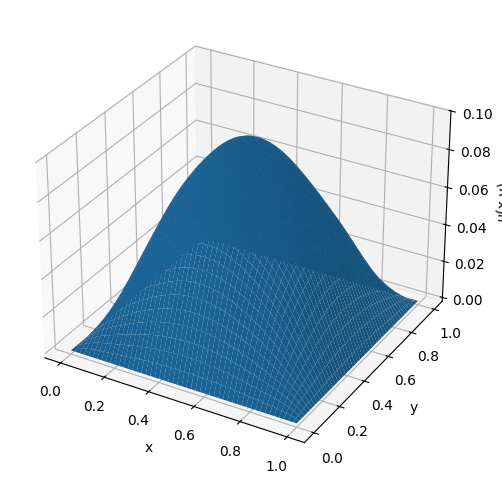

In [120]:
#Sanity test 
from src.solver_utils import solve_precond

elems=list(bh.basis[0].values())


def u_exact(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_rhs(x, y, s=1):
    # f(x, y) = (2π²)^s * sin(πx) sin(πy)
    return (2 * np.pi**2)**s * np.sin(np.pi * x) * np.sin(np.pi * y)

b=bh.project_f_2d(f_rhs,level=0)

x=solve_precond(M,b)
u_num=reconstruct_solution(x,elems)


l2err=l2_error(u_num, u_exact)
print(f"L2 error: {l2err}")

n=200
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
Z = u_num(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")

plt.show()